In [133]:
#https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab

from google.cloud import bigquery
from datetime import date, timedelta, datetime 

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)

2.12.0


In [134]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [135]:
model_tree_type=2# 1= xgboost  2-random forest
option_cate_feature=1

labelCol='label_multi_severity'
# labelCol='label_binary_severity'

In [136]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'

train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [137]:
metric="accuracy"

if model_tree_type==1:
    _model='model_tuned_xgb_tf'
else:
     _model='model_tuned_rf_tf'

model_gs_path=f"gs://demo-tuned-tf-incident-pongthorn/{_model}"
print(model_gs_path)
#model_local_path=_model

gs://demo-tuned-tf-incident-pongthorn/model_tuned_rf_tf


In [138]:
if option_cate_feature==1:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour']
else:
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    unusedCols=['id','severity_id','severity_name','label_binary_severity','range_open_to_close_hour']




# Load & Prepare Data

In [139]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [140]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241 entries, 0 to 2240
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   label_multi_severity      2241 non-null   int64 
 1   sla                       2241 non-null   object
 2   product_type              2241 non-null   object
 3   brand                     2241 non-null   object
 4   service_type              2241 non-null   object
 5   incident_type             2241 non-null   object
 6   range_open_to_close_hour  2241 non-null   object
dtypes: int64(1), object(6)
memory usage: 122.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   label_multi_severity      561 non-null    int64 
 1   sla                       561 non-null    object
 2   product_type              

In [141]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
classes

[0, 1, 2, 3]

In [142]:
train.tail(5)

,label_multi_severity,sla,product_type,brand,service_type,incident_type,range_open_to_close_hour
2236,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Configuration Change,soonest
2237,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,OS / Firmware,latest
2238,0,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,soonest
2239,0,24x7 4Hrs Response Time,Security,Trend Micro,Request,Upgrade Software,fair
2240,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soonest


In [143]:
test.tail()

,label_multi_severity,sla,product_type,brand,service_type,incident_type,range_open_to_close_hour
556,0,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Request,Software,late
557,3,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,soonest
558,1,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,late
559,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soon
560,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,soon


# Tune Model

## Training a model with automated hyper-parameter tuning and automatic definition of the hyper-parameters (recommended approach)

As before, hyper-parameter tuning is enabled by specifying the tuner constructor argument of the model. Set use_predefined_hps=True to automatically configure the search space for the hyper-parameters.

In [144]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

In [145]:
import time

t_Start=time.time()

print(f"Start tund at {datetime.now()}")

Start tund at 2023-07-08 15:51:22.208505


In [146]:
tuner = tfdf.tuner.RandomSearch(num_trials=50, use_predefined_hps=True)
# Specify the model.
if model_tree_type==1:
    print("GradientBoostedTreesModel")
    tuned_model=tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
else:
    print("RandomForestModel")
    tuned_model = tfdf.keras.RandomForestModel(tuner=tuner)

tuned_model.fit(x=train_ds,verbose=2)

RandomForestModel
Use /var/tmp/tmpgxiuwd92 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'sla': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'product_type': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'brand': <tf.Tensor 'data_2:0' shape=(None,) dtype=string>, 'service_type': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'incident_type': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>, 'range_open_to_close_hour': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>}
Label: Tensor("data_6:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'sla': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>), 'product_type': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_1:0' shape=(None,) dtype=string>), 'brand': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_2:0' shape=(None,) dtype=string>), 'serv

2023-07-08 15:51:22.525739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [2241]
	 [[{{node Placeholder/_6}}]]


Training dataset read in 0:00:00.188594. Found 2241 examples.
Training model...


[INFO 23-07-08 15:51:22.7195 UTC kernel.cc:773] Start Yggdrasil model training
[INFO 23-07-08 15:51:22.7196 UTC kernel.cc:774] Collect training examples
[INFO 23-07-08 15:51:22.7196 UTC kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-07-08 15:51:22.7197 UTC kernel.cc:393] Number of batches: 3
[INFO 23-07-08 15:51:22.7197 UTC kernel.cc:394] Number of examples: 2241
[INFO 23-07-08 15:51:22.7205 UTC data_spec_inference.cc:305] 9 item(s) have been pruned (i.e. they are considered out of dictionary) for the column brand (17 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO 23-07-08 15:51:22.7205 UTC data_spec_inferen

Model trained in 0:02:27.280888
Compiling model...


2023-07-08 15:53:50.018540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [2241]
	 [[{{node Placeholder/_2}}]]


Model compiled.


In [148]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  0.08
2023-07-08 15:56:19.066607


# Evaluate the model

In [149]:
tuned_model.compile(["accuracy"])
tuned_test_accuracy = tuned_model.evaluate(test_ds, return_dict=True, verbose=0)["accuracy"]
print(f"Test accuracy with the TF-DF hyper-parameter tuner: {tuned_test_accuracy:.4f}")

2023-07-08 15:56:22.984596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [561]
	 [[{{node Placeholder/_6}}]]


Test accuracy with the TF-DF hyper-parameter tuner: 0.7059


# Inspect and debug decision forest models
## Model structure and feature importance

In [150]:
# Display the tuning logs.
tuning_logs = tuned_model.make_inspector().tuning_logs()
tuning_logs.head()

,score,evaluation_time,best,split_axis,sparse_oblique_projection_density_factor,sparse_oblique_normalization,sparse_oblique_weights,categorical_algorithm,winner_take_all,max_depth,min_examples
0,0.705042,1.011091,False,SPARSE_OBLIQUE,5.0,MIN_MAX,BINARY,CART,true,12,40
1,0.720214,3.448616,False,SPARSE_OBLIQUE,5.0,MIN_MAX,CONTINUOUS,CART,true,16,1
2,0.740741,6.737096,False,SPARSE_OBLIQUE,4.0,MIN_MAX,CONTINUOUS,RANDOM,true,16,10
3,0.724230,9.026426,False,SPARSE_OBLIQUE,4.0,STANDARD_DEVIATION,BINARY,CART,true,25,2
4,0.736725,10.593147,False,SPARSE_OBLIQUE,1.0,MIN_MAX,CONTINUOUS,CART,true,20,10


In [151]:
# Best hyper-parameters.
tuning_logs[tuning_logs.best].iloc[0]

score                                             0.742526
evaluation_time                                  95.078428
best                                                  True
split_axis                                  SPARSE_OBLIQUE
sparse_oblique_projection_density_factor               4.0
sparse_oblique_normalization                          NONE
sparse_oblique_weights                          CONTINUOUS
categorical_algorithm                               RANDOM
winner_take_all                                       true
max_depth                                               12
min_examples                                             5
Name: 32, dtype: object

# Plotting the training logs

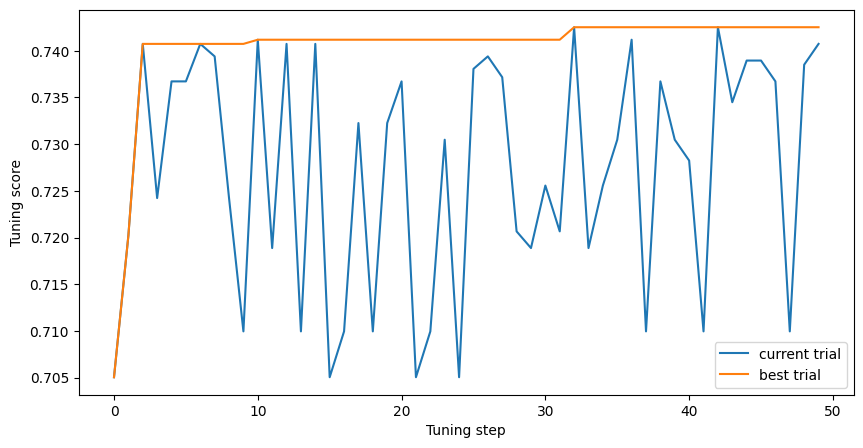

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()

# Save Model

In [153]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
tuned_model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/model_tuned_rf_tf/assets


INFO:tensorflow:Assets written to: gs://demo-tuned-tf-incident-pongthorn/model_tuned_rf_tf/assets
